# Introduction

In this notebook we'll go over defining, training and testing as well as the pre-processing steps needed to feed an image into CNNs to get state of the art results. We'll be using PyTorch for this tutorial. PyTorch is a powerful deep learning framework which is rising in popularity, and it is thoroughly at home in Python which makes it really easy to learn and use. This tutorial won’t assume much in regards to prior knowledge of PyTorch, but it might be helpful to checkout [my previous introductory CV tutorial](https://www.kaggle.com/abhinand05/mnist-introduction-to-computervision-with-pytorch). 


![FeaturedImage](https://i.ibb.co/ws3htpn/2088474-6a86-3.jpg)



In this notebook, we'll train a CNN to classify images based on whether they have a columnar cactus or not. We'll use the Aerial Cactus Dataset from [this currently running Kaggle competition](https://www.kaggle.com/c/aerial-cactus-identification/overview). For more information about the dataset visit [this page](https://www.kaggle.com/c/aerial-cactus-identification/data). I picked this competition because I felt it is the best place for beginners to practice their new found skills with CNNs as MNIST is just way too simple to bring CNNs into play, a regular Multi-layer perceptron may well do the job. So, this is a perfect beginners competition as someone rightly said in the discussion forums. 

### **If you like this kernel or wish to fork it please give it an UPVOTE to show your appreciation.**

# Import Libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# print(os.listdir("train/train"))
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# OpenCV Image Library
import cv2

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

## Loading Training Data + EDA

In [4]:
train_df = pd.read_csv("train.csv")
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


The train data contains 17500 images which can be found in a seperate directory also we have a csv file but we can't directly visualize them as we'll see later.

The test data has 4000 images and it is stored in a seperate directory. Note that it doesn't have a csv file as we saw for the train data.

In [5]:
print(f"Train Size: {len(os.listdir('train/train'))}")
print(f"Test Size: {len(os.listdir('test/test'))}")

Train Size: 17500
Test Size: 4000


Here we inspect the data to see the amount of training samples for each class. As we can see about 2/3 of the training data belongs to one class. If the dataset you are using contains almost or above 90% of the training data belonging to one single class then it will greatly impact your results. This is called skewed classes, we can use data augmentation, sampling and several ways to overcome this. However I don't believe that's a problem here as we have enough data for CNNs to get great results. 

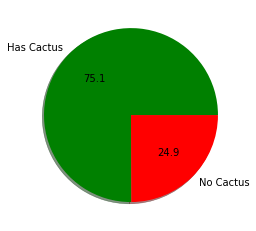

<Figure size 360x360 with 0 Axes>

In [6]:
# Counting the number of sample data for each class
value_counts = train_df.has_cactus.value_counts()
%matplotlib inline
plt.pie(value_counts, labels=['Has Cactus', 'No Cactus'], autopct='%1.1f', colors=['green', 'red'], shadow=True)
plt.figure(figsize=(5,5))
plt.show()

## Setting up Train Data for Pytorch 
We cannot simply use the raw image data to make predictions using PyTorch. There are several pre-processing steps involved which we'll discuss in detail in this section.

**Step 1:** 

First up we define a custom class that extends PyTorch's `torch.utils.data.Dataset` class. I think everything in there is pretty straight-forward. We define our constructors and add two different methods `len` and `getitem` which essentially replaces the parent definitions.  

In [7]:
# Data paths
train_path = 'train/train/'
test_path = 'test/test/'

In [17]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

**Step 2:**

Now that we've defined our class it is time to pass the raw data and convert it to PyTorch understandable form. 

**Transforms** - We can use the transforms feature in PyTorch to apply Data Augmentations which help us improve the accuracy of our model when done right. There are sevaral transformations that can be applied for which you may want to have a look at the [documentation here](https://pytorch.org/docs/stable/torchvision/transforms.html). Here we conert it to a PIL image first. Random horizontal flipping of sample images is applied along with random rotation of 10 degrees for random training examples. We then convert the images into a PyTorch tensor then we normalize the them.

**Creating our Dataset -** We then use our `CreateDataset` class to covert the raw data in the way PyTorch expects. We have also applied the transformations there. 

In [18]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

**Step 3:** 

Batch size is set. The batch size is usually set between 64 and 256. The batch size does have an effect on the final test accuracy. One way to think about it is that smaller batches means that the number of parameter updates per epoch is greater. 

Then the percentage of data needed for validation is set to 20%, which almost always seem to work for me. But in the end it's just another hyperparameter you can tune.

In the next steps we use the `torch.utils.data.samplerSubsetRandomSampler` function to split our data into training and validation sets, which is similar to `train_test_split` fuction of scikit-learn.

We have the training data passed into the trainloader. We can make an iterator with iter(trainloader) that can help us grab data. Later, we'll use this to loop through the dataset for training. Each time we can pull out data of the size of the batch_size defined.

In [25]:
# Set Batch Size
batch_size = 64

# Percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

## Setting up Test Data
This section of code should make sense to you now. The same steps used above are repeated for the test data as well. 

Note that we don't augment our data on the training set. This is because augmentation is only done on the training set to improve the performance by giving our model complex variations that might make it generalize well to new samples on the test set, so it doesn't make sense to do data augmentation on the test data as well. However we still need to convert it to a tensor and normalize it.

In [26]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# creating test data
sample_sub = pd.read_csv("sample_submission.csv")
test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

# prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Visualize Images

Visualizing the images and inspecting them to get a better idea of what they are is always helpful before going on the construct our model to make predictions.

We can see aerial images of cactus. The images contain color channels, we should keep in mind and they are 32x32 images. Note that these images are very low  inresolution yet as humans we have evolved in such a way to make sense of even these kind of pictures. We're going to build a CNN in the next few sections to ultimately achieve just that or even better performance.

In [27]:
classes = [ 'No Cactus','Cactus']

In [28]:
def imshow(img):
    '''Helper function to un-normalize and display an image'''
    # unnormalize
    img = img / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))

<ipython-input-29-2181f8df30a5>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


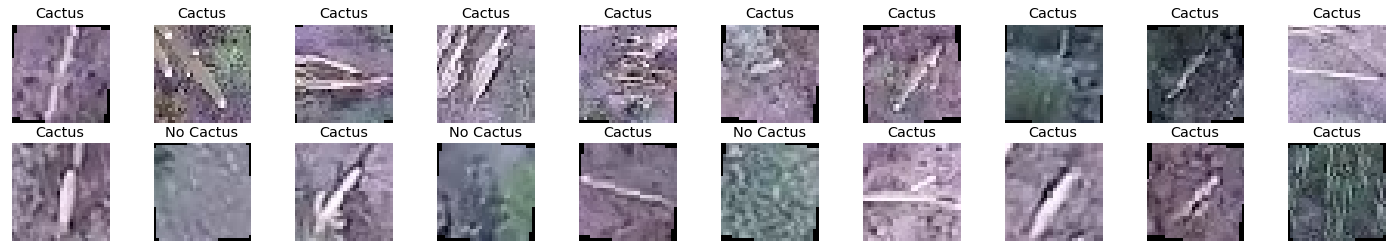

In [29]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Viewing an Image in More Detail
Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images for illustration purposes. This helps me explain CNNs later.

Each little square you can see are pixels with their normalized values. Larger value means brighter, lower means darker. This is how images are represented in our computers. When we combine all three channels we get a color image. This RGB color scheme can represent about 16.77 million colors, which is awesome. 

As you might have guessed already color images are actually three dimensional, where Greyscale images for example are 1D.

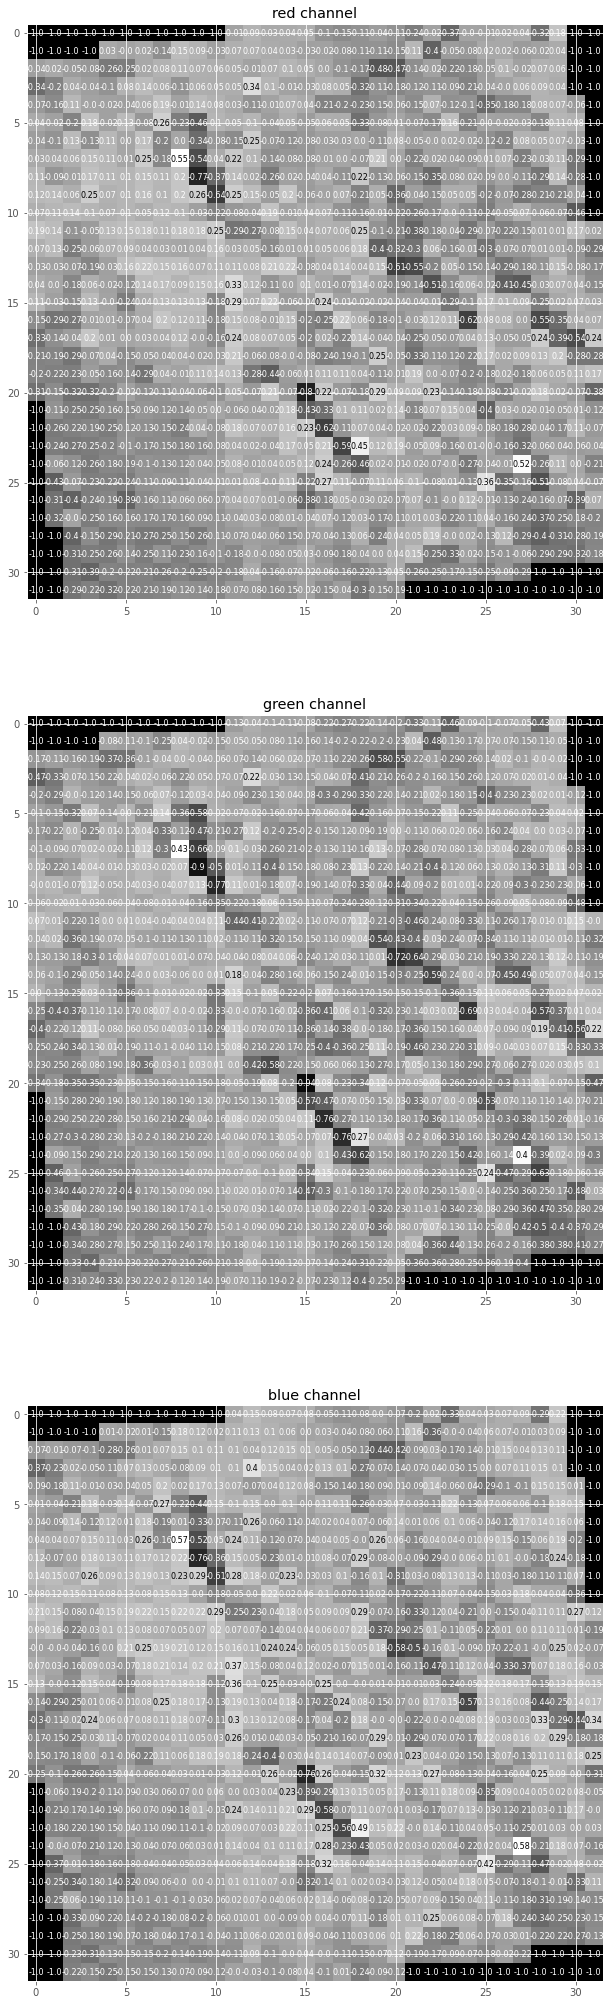

In [32]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(3, 1, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Multi-Layer Perceptrons (MLP) Vs Convolutional Neural Networks (CNN)
As you might have seen in [my previous tutorial](https://www.kaggle.com/abhinand05/mnist-introduction-to-computervision-with-pytorch) on MNIST dataset, MLPs were good enough to score more than 90% accuracy. It turns out that they're nowhere near good enough to achieve similar results on complex datasets mainly because they expect a flattened vector of the original image like the one below. MNIST dataset is an exception as it comes already well processed.

![Example](https://github.com/abhinand5/CNNs-in-PyTorch/blob/master/cifar-cnn/FireShot%20Capture%20084%20-%20Intro%20to%20Deep%20Learning%20with%20PyTorch%20-%20Udacity%20-%20classroom.udacity.com.png?raw=true)

So all it sees is a vector and treats it just as a vector with no special structure. It has no knowledge whatsoever of the fact that it was previously arranged in a grid, losing important information. If we do the same for color images we throw away vital information by flattening it, which almost never works for real-world images. CNNs on the other hand work exactly the other way around, capable of working with and elucidating patterns from multi-dimensional data, that is why they are so powerful. Unlike MLPs CNNs actually understand the information from pixels that are in close proximity to each other and are more related to each other than those pixels that are far apart and unrelated. 


## Understanding CNNs

Conolutional Neural Networks make use of three different classes of layers which distinctly differ with each other. But when combined they give extraordinary results. 

* Convolutional Layers
* Pooling Layers
* Fully Connected Layers

We'll go over each one of there layers in great detail. 

I'll use an example of classifying a car here to explain different layers of a Convolutional Neural Network.

![Layers](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5b1070e4_screen-shot-2018-05-31-at-2.59.36-pm/screen-shot-2018-05-31-at-2.59.36-pm.png)

**Convolutional Layer:**

Turns out that in order to understand Convolutional layer first we have to understand a concept called Filters. Expecially high-pass filters. 

To detect changes in intensity in an image, we'll be using and creating specific image filters that look at groups of pixels and react to alternating patterns of dark/light pixels. These filters produce an output that shows edges of objects and differing textures. 

For this we first contstruct a filter according to a size called window size, which is nothing but a matrix like this.

Here in an example gif.

![Example](https://media.giphy.com/media/jrzu0JxxZydz0valeu/giphy.gif)

These windows are usually of size 3x3 which helps CNNs identify the patterns in an image. These filters can be modified to get different filters as output. There may be several filters in a Convolutional layer.

The convolutional layer is produced by applying a series of many different image filters, also known as convolutional kernels, to an input image.

![Example](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5b10723a_screen-shot-2018-05-31-at-3.06.07-pm/screen-shot-2018-05-31-at-3.06.07-pm.png)

In the example shown, 4 different filters produce 4 differently filtered output images. When we stack these images, we form a complete convolutional layer with a depth of 4!

![Example](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5b10729b_screen-shot-2018-05-31-at-3.07.03-pm/screen-shot-2018-05-31-at-3.07.03-pm.png)

The depth of each consecutive convolutional layers may increase resulting in the networks capturing some incredibly complex features/patterns from the images. In fact this is very much similar to how our brains interpret images in an instant. 

**Pooling Layer:**

Pooling is used in Convolutional Neural Networks to make the detection of certain features somewhat invariant to scale and orientation changes. Another way of thinking about what pooling does is that it generalizes over lower level, more complex information.

How it is done is a window of fixed size of made to stroll over the image and inside the window a specific value according to a metric is calculated an a new tensor is formed. When we take the maximum element from the window it is known as Max-Pooling which is the most common pooling technique. There is also average pooling which you may see out on the wild. Here is an illustration which you might find helpful. There are also alternatives to Pooling, like Capsule Networks which is out of the score of this kernel. 

Here in an example gif of Max Pooling.

![Example](https://media.giphy.com/media/U7PsR7cv9oIcB6eEAd/giphy.gif)

When we combine pooling layers with convolutional layers, we reduce the dimension of the layers which helps in computation but more than that it picks the pixel values of higher significance. So our model so far looks something like this...

![Example](https://i.ibb.co/V06mcY0/Intro-to-Deep-Learning-with-Py-Torch-Udacity-classroom-udacity-com.png)

**Fully Connected Layers:**

Fully connected layers are no different from the ones you already know from MLPs. It is the final piece of the puzzle that makes it special and powerful. An even more refined form is passed on to FC layers to make the final prediction.

Here comes our final model...

![Example](http://cs231n.github.io/assets/cnn/convnet.jpeg)


I know this may not be the best of definitions you would see for CNNs but the goal here is to make it atleast vaguely understandable. There is much more happening behind the scenes which I skipped. I encourage you to go out and explore on your own to find those awesome stuff. Hope it made sense to you. Let's move on.

### **If you like this kernel or wish to fork it please give it an UPVOTE to show your appreciation.**

Image Credits: Stanford CS231n, Udacity

## Define the Network Architecture

Here comes the important part of defining a CNN which will can done using the `torch.nn` module . First, you must define a Model class and fill in two functions `__init__` and `__forward__`. Now that you understand how a CNN works everything is pretty much self-explanatory. Read the docs for `nn.Conv2d` to know more about the parameters. 

* We define the convolutional layers first. Details can be mostly interpreted from the comment lines itself. But let me just explain one. Our image (RGB) has 3 channels so depth=3, that's why our first conv layer has 3 incoming channels, I've decided to have 16 filters for the first conv layer so out_channels=16 as it produces 16 different filters, the kernel size aka window size is set to 3 with padding=1 which makes up extra spaces on the edges of the image to help the 3x3 kernel slide over all the edge pixels of the image in case of size mismatch. 

* We then go on and define the pooling layers where a window size and stride of 2 is set. Exactly same as the example gif you saw previously. 

* The outputs are then connected to a FC layer.

* Dropout is a regularization technique to avoid overfitting, which is also added. Everything is  put together in a forward propagation function later. 

* You might also want to use Batch Normalization but I decided not to because I achieved more than 99% accuracy without it.

* The outputs here don't need to be 0 or 1, what Kaggle expects is the probabilities so we don't need an activation function like sigmoid on the output layer.

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Layer (sees 32x32x3 image tensor) 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Convolutional Layer (sees 16x16x16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # Convolutional Layer (sees 8x8x32 image tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # Convolutional Layer (sees 4*4*64 image tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # Maxpooling Layer
        self.pool = nn.MaxPool2d(2, 2)
        # Linear Fully-Connected Layer 1 (sees 2*2*128 image tensor)
        self.fc1 = nn.Linear(128*2*2, 512)
        # Linear FC Layer 2
        self.fc2 = nn.Linear(512, 2)
        # Set Dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input
        x = x.view(-1, 128 * 2 * 2)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

In [34]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [35]:
# create a complete CNN
model = CNN()
print(model)

# Move model to GPU if available
if train_on_gpu: model.cuda()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Training our CNN

Now the training steps are same as that of training an MLP which I explained in a previous kernel. The only difference here is that I'm saving the model everytime the validation loss decreases. Finally we'll get the best model params learned. This is one type of early stopping.

In [38]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adamax(model.parameters(), lr=0.001)

In [39]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

# keeping track of losses as it happen
train_losses = []
valid_losses = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.015670 	Validation Loss: 0.027420
Validation loss decreased (inf --> 0.027420).  Saving model ...
Epoch: 2 	Training Loss: 0.015964 	Validation Loss: 0.026218
Validation loss decreased (0.027420 --> 0.026218).  Saving model ...
Epoch: 3 	Training Loss: 0.010845 	Validation Loss: 0.021995
Validation loss decreased (0.026218 --> 0.021995).  Saving model ...
Epoch: 4 	Training Loss: 0.011814 	Validation Loss: 0.031328
Epoch: 5 	Training Loss: 0.010936 	Validation Loss: 0.029068
Epoch: 6 	Training Loss: 0.012206 	Validation Loss: 0.022155
Epoch: 7 	Training Loss: 0.009105 	Validation Loss: 0.014230
Validation loss decreased (0.021995 --> 0.014230).  Saving model ...
Epoch: 8 	Training Loss: 0.008489 	Validation Loss: 0.023057
Epoch: 9 	Training Loss: 0.008886 	Validation Loss: 0.017077
Epoch: 10 	Training Loss: 0.008315 	Validation Loss: 0.014246
Epoch: 11 	Training Loss: 0.007543 	Validation Loss: 0.019624
Epoch: 12 	Training Loss: 0.008278 	Validation Loss: 0.0

## Performance Graph
I told you how powerful CNNs are now look at that graph. We've achieved state of the art results as promised. 

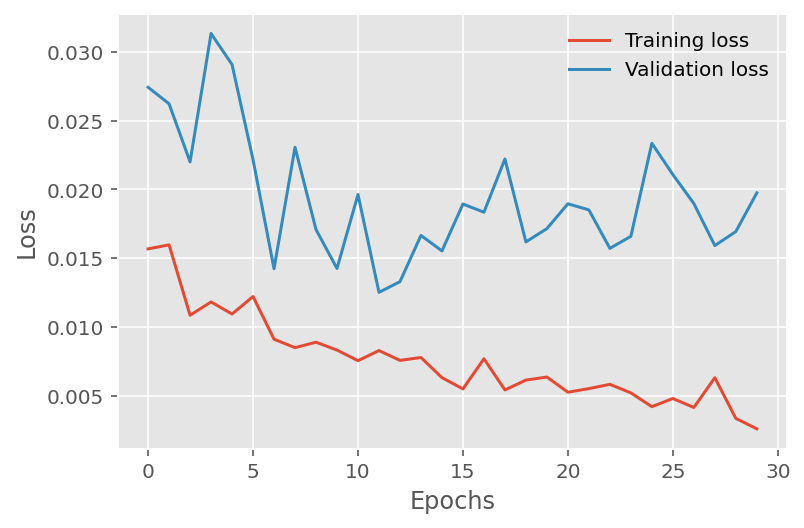

In [41]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [42]:
# Load Best parameters learned from training into our model to make predictions later
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

## Make Predictions on Test Set

In [43]:
# Turn off gradients
model.eval()

preds = []
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

# Create Submission file        
sample_sub['has_cactus'] = preds
sample_sub.to_csv('submission.csv', index=False)

AssertionError: Torch not compiled with CUDA enabled

### **If you like this kernel or wish to fork it please give it an UPVOTE to show your appreciation.**

**Authored By:**

[Abhinand](https://www.kaggle.com/abhinand05)